# Chapter 10: Explainable AI Using LIME and SHAP

Outline
----
CHAPTER 9:Explainable AI - Using LIME and SHAP - 25 pages
DESCRIPTION: 

It’s not enough to just say “This is the answer”, you need to show your work. Find out how to use techniques to extract how different models arrived at their answer. Explain LIME, and how you can use it to do just that.

Level: Advanced

Main Chapter Headings (3-5 main chapter headings)


### Skills learned: 
For each heading, insert what the reader will learn to DO in this chapter?

SKILL 1: Import LIME using Conda

SKILL 2: Using some prebuilt models, determine how it got there



In [1]:
# Importing all needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

from sklearn.linear_model import LogisticRegression
from sklearn import tree

# from sklearn.linear_model import LinearRegression
# from sklearn.svm import SVR
# from sklearn.neighbors import KNeighborsRegressor


from sklearn.ensemble import RandomForestClassifier

In [2]:
# Import datasets
df =  pd.read_csv('heart.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [4]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [5]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

### Dataset information

Age: age of the patient in years

Sex: sex of the patient (M: Male, F: Female)

ChestPainType: chest pain type 
-TA: Typical Angina
-ATA: Atypical Angina 
-NAP: Non-Anginal Pain
-ASY: Asymptomatic]

RestingBP: resting blood pressure (mm Hg)

Cholesterol: serum cholesterol (mm/dl)

FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]

RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]

MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]

ExerciseAngina: exercise-induced angina [Y: Yes, N: No]

Oldpeak: oldpeak = ST [Numeric value measured in depression]

ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]

**(Target feature) HeartDisease: output class [1: heart disease, 0: Normal]**

<AxesSubplot:>

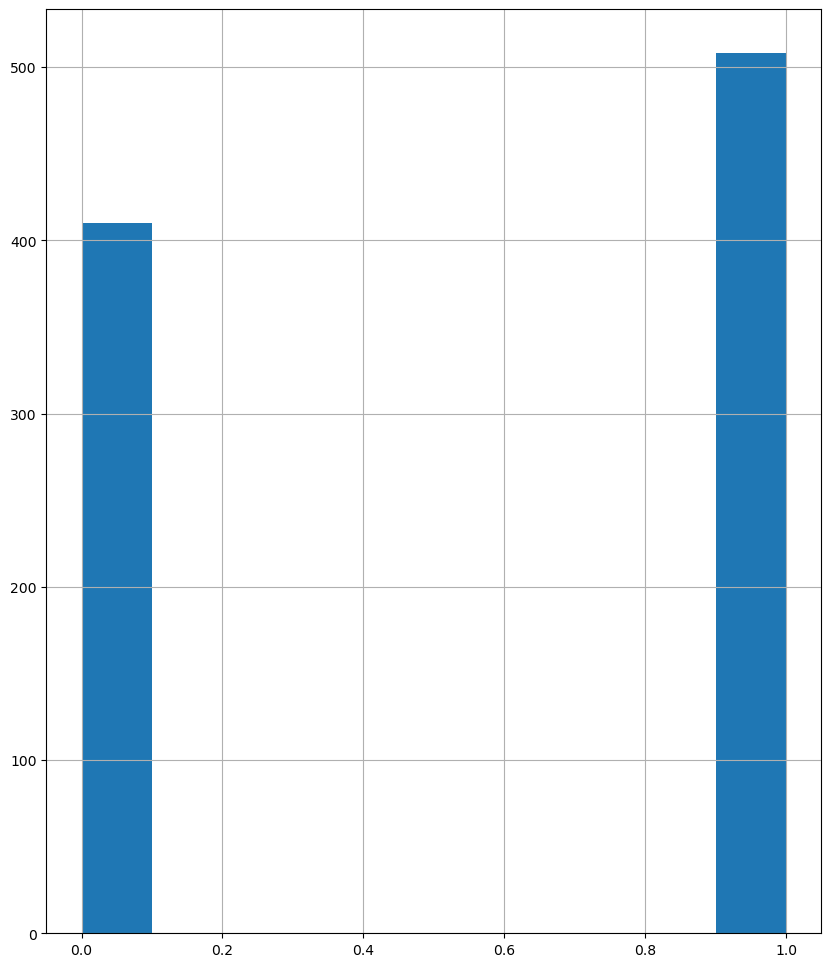

In [6]:
df["HeartDisease"].hist(figsize = (10,12))

In [7]:
# One hot encode the sex, ChestPainType, RestingECG, ExerciseAngina, ST_Slope
categorical_columns = ['Sex','ChestPainType','RestingECG','ExerciseAngina','ST_Slope']
prefix = ['Sex_','ChestPainType_','RestingECG_','ExerciseAngina_','ST_Slope_']
one_hot_df = pd.get_dummies(df, prefix =prefix, columns = categorical_columns, drop_first=True) 

one_hot_df

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex__M,ChestPainType__ATA,ChestPainType__NAP,ChestPainType__TA,RestingECG__Normal,RestingECG__ST,ExerciseAngina__Y,ST_Slope__Flat,ST_Slope__Up
0,40,140,289,0,172,0.0,0,1,1,0,0,1,0,0,0,1
1,49,160,180,0,156,1.0,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,0,1,1,0,0,0,1,0,0,1
3,48,138,214,0,108,1.5,1,0,0,0,0,1,0,1,1,0
4,54,150,195,0,122,0.0,0,1,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,110,264,0,132,1.2,1,1,0,0,1,1,0,0,1,0
914,68,144,193,1,141,3.4,1,1,0,0,0,1,0,0,1,0
915,57,130,131,0,115,1.2,1,1,0,0,0,1,0,1,1,0
916,57,130,236,0,174,0.0,1,0,1,0,0,0,0,0,1,0


In [8]:
y = one_hot_df['HeartDisease']
X = one_hot_df.drop(['HeartDisease'],axis=1)

In [9]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 918 non-null    int64  
 1   RestingBP           918 non-null    int64  
 2   Cholesterol         918 non-null    int64  
 3   FastingBS           918 non-null    int64  
 4   MaxHR               918 non-null    int64  
 5   Oldpeak             918 non-null    float64
 6   Sex__M              918 non-null    uint8  
 7   ChestPainType__ATA  918 non-null    uint8  
 8   ChestPainType__NAP  918 non-null    uint8  
 9   ChestPainType__TA   918 non-null    uint8  
 10  RestingECG__Normal  918 non-null    uint8  
 11  RestingECG__ST      918 non-null    uint8  
 12  ExerciseAngina__Y   918 non-null    uint8  
 13  ST_Slope__Flat      918 non-null    uint8  
 14  ST_Slope__Up        918 non-null    uint8  
dtypes: float64(1), int64(5), uint8(9)
memory usage: 51.2 KB


In [10]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=33)

In [11]:
# Scale the data
min_max_scaler = MinMaxScaler()

minmax_scaled_X = min_max_scaler.fit_transform(X_train)

df_minmax_scaled_X = pd.DataFrame(minmax_scaled_X,columns=X.columns)
df_minmax_scaled_X.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex__M,ChestPainType__ATA,ChestPainType__NAP,ChestPainType__TA,RestingECG__Normal,RestingECG__ST,ExerciseAngina__Y,ST_Slope__Flat,ST_Slope__Up
0,0.836735,0.500000,0.368794,0.0,0.553957,0.487805,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
1,0.795918,0.516667,0.478723,1.0,0.446043,0.548780,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
2,0.673469,0.333333,0.500000,0.0,0.517986,0.731707,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,0.673469,0.583333,0.000000,0.0,0.388489,0.487805,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
4,0.387755,0.666667,0.466312,0.0,0.798561,0.243902,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


### Decision Trees

In [12]:
dt_clf = tree.DecisionTreeClassifier(random_state=33, max_depth = 3)

dt_clf = dt_clf.fit(df_minmax_scaled_X,y_train)

In [13]:
from sklearn.tree import plot_tree, export_text

[Text(0.5, 0.875, 'ST_Slope__Up <= 0.5\ngini = 0.496\nsamples = 100.0%\nvalue = [0.458, 0.542]\nclass = y[1]'),
 Text(0.25, 0.625, 'MaxHR <= 0.633\ngini = 0.295\nsamples = 56.8%\nvalue = [0.18, 0.82]\nclass = y[1]'),
 Text(0.125, 0.375, 'Sex__M <= 0.5\ngini = 0.212\nsamples = 47.4%\nvalue = [0.121, 0.879]\nclass = y[1]'),
 Text(0.0625, 0.125, 'gini = 0.476\nsamples = 6.3%\nvalue = [0.391, 0.609]\nclass = y[1]'),
 Text(0.1875, 0.125, 'gini = 0.146\nsamples = 41.1%\nvalue = [0.079, 0.921]\nclass = y[1]'),
 Text(0.375, 0.375, 'ChestPainType__NAP <= 0.5\ngini = 0.499\nsamples = 9.4%\nvalue = [0.478, 0.522]\nclass = y[1]'),
 Text(0.3125, 0.125, 'gini = 0.422\nsamples = 5.9%\nvalue = [0.302, 0.698]\nclass = y[1]'),
 Text(0.4375, 0.125, 'gini = 0.355\nsamples = 3.5%\nvalue = [0.769, 0.231]\nclass = y[0]'),
 Text(0.75, 0.625, 'Cholesterol <= 0.075\ngini = 0.291\nsamples = 43.2%\nvalue = [0.823, 0.177]\nclass = y[0]'),
 Text(0.625, 0.375, 'FastingBS <= 0.5\ngini = 0.424\nsamples = 4.9%\nvalue =

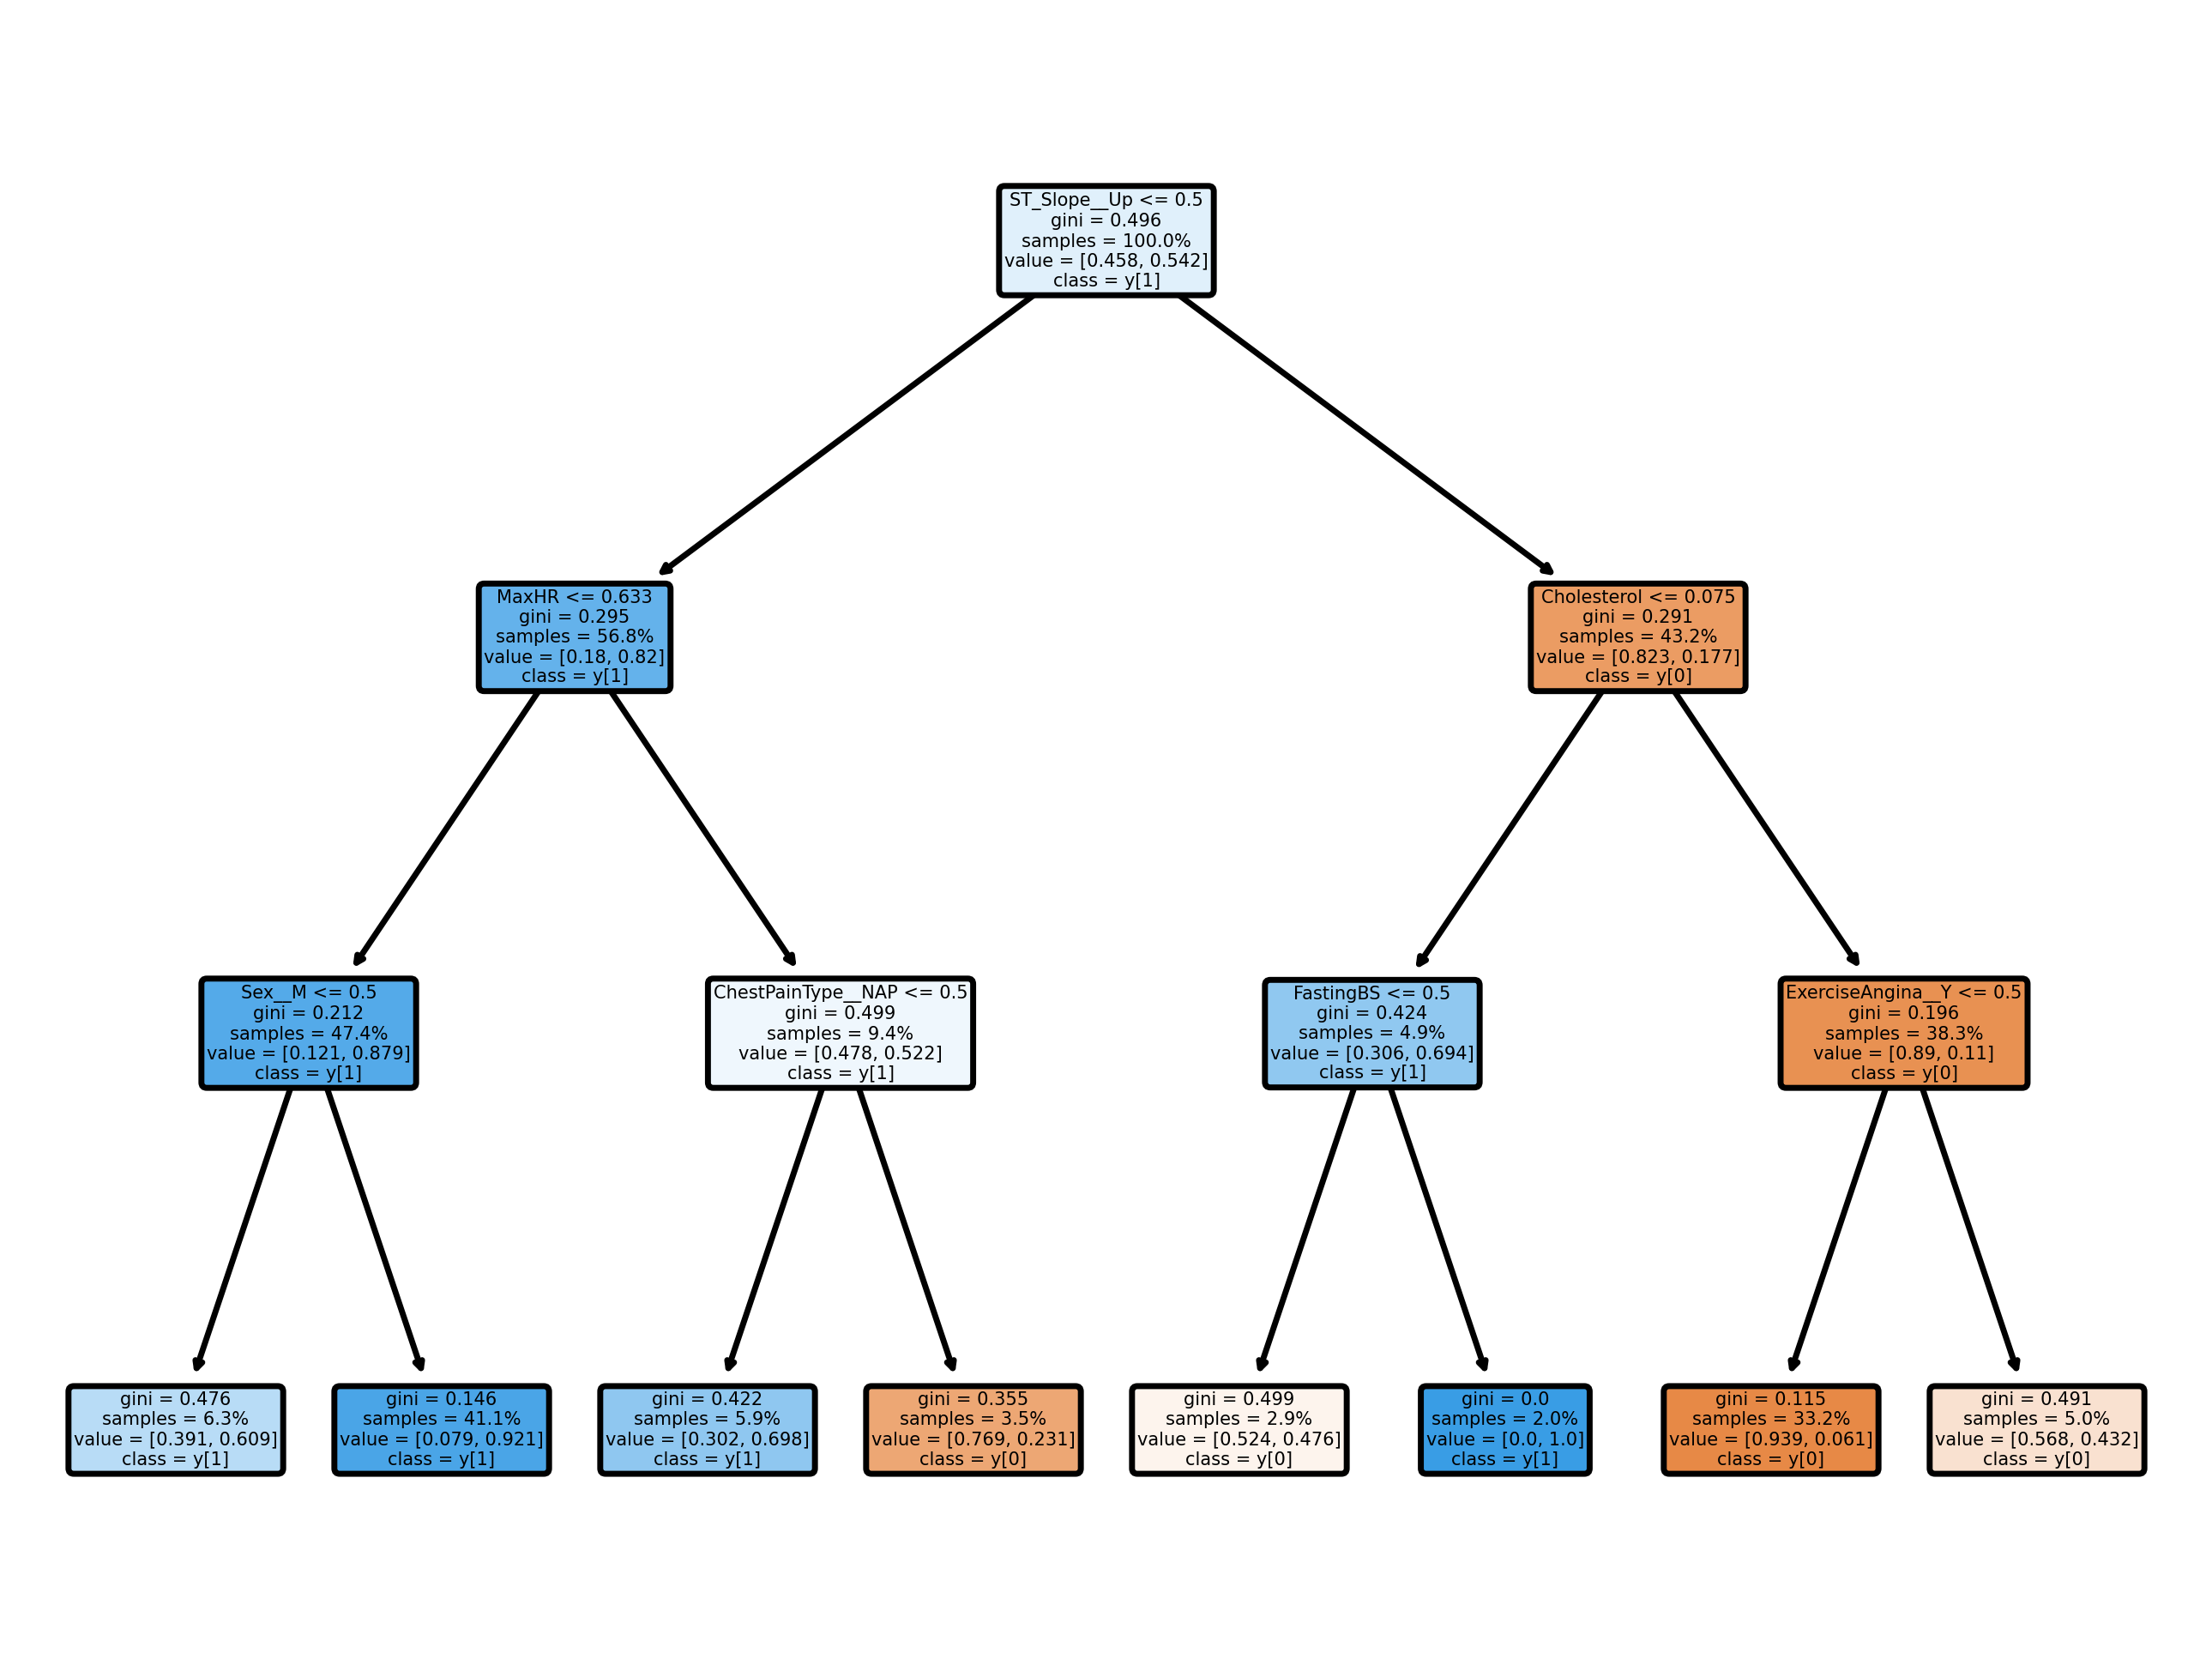

In [14]:
# plt.figure(figsize=(8,6))
plt.figure(dpi=500)
plot_tree(dt_clf, class_names = True, feature_names=X.columns.values, filled = True, proportion = True, rounded = True)

### Logistic Regression

In [15]:
kfold = StratifiedKFold(n_splits=3, random_state=33, shuffle=True)

lr = LogisticRegression(max_iter=300)
lr.fit(df_minmax_scaled_X,y_train)

lr_cve = cross_val_score(lr, df_minmax_scaled_X, y_train, cv=kfold, scoring='f1')


In [16]:
print(f'Logistic Regression f1 score: {lr_cve.mean()}')

Logistic Regression f1 score: 0.8808047298613335


In [17]:
# Test out on test data

minmax_scaled_X_test = min_max_scaler.fit_transform(X_test)
df_minmax_scaled_X_test = pd.DataFrame(minmax_scaled_X_test,columns=X.columns)

lr_cve_test = cross_val_score(lr, df_minmax_scaled_X_test, y_test, cv=kfold, scoring='f1')
rd_f1_test = f1_score(y_test, lr.predict(df_minmax_scaled_X_test))

In [18]:
print(f'(Test) Logistic Regression f1 score: {lr_cve_test.mean()}')
print(f'(Test)  Random Forest Regression f1 score: {rd_f1_test.mean()}')

(Test) Logistic Regression f1 score: 0.8765117923012661
(Test)  Random Forest Regression f1 score: 0.8623853211009175


# HEADING 4: Explaining model outcome with LIME 

## Random Forest

In [19]:
df_minmax_scaled_X_test

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex__M,ChestPainType__ATA,ChestPainType__NAP,ChestPainType__TA,RestingECG__Normal,RestingECG__ST,ExerciseAngina__Y,ST_Slope__Flat,ST_Slope__Up
0,0.583333,0.610,0.437811,0.0,0.296296,0.382353,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.562500,0.625,0.000000,1.0,0.318519,0.529412,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2,0.479167,0.650,0.373134,0.0,0.444444,0.676471,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
3,0.937500,0.690,0.000000,0.0,0.414815,0.411765,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.687500,0.650,0.383085,0.0,0.637037,0.647059,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,0.854167,0.700,0.000000,1.0,0.718519,0.676471,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
180,0.333333,0.575,0.431177,0.0,0.925926,0.382353,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
181,0.145833,0.750,0.265340,0.0,0.829630,0.382353,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
182,0.583333,0.600,0.587065,0.0,0.762963,0.470588,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


In [20]:
rf = RandomForestClassifier(random_state=33)
rf.fit(df_minmax_scaled_X,y_train)
rf_f1 = f1_score(y_train, rf.predict(df_minmax_scaled_X))

print(f'Random Forest Regression f1 score: {rf_f1.mean()}')

Random Forest Regression f1 score: 1.0


In [21]:
minmax_scaled_X_test = min_max_scaler.fit_transform(X_test)
rf_f1 = f1_score(y_test, rf.predict(minmax_scaled_X_test))

print(f'Random Forest Regression f1 score: {rf_f1.mean()}')

Random Forest Regression f1 score: 0.8761061946902655


/home/gregorywpower/anaconda3/envs/BuildingDSSWithAnaconda/lib/python3.10/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [22]:
rf.estimators_[2].feature_importances_

array([0.02533912, 0.07962327, 0.11314904, 0.02609705, 0.10902368,
       0.13216554, 0.03537417, 0.00924883, 0.03931191, 0.00325471,
       0.01929674, 0.00519294, 0.0210267 , 0.35346602, 0.02843028])

In [23]:
import time

start_time = time.time()
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.008 seconds


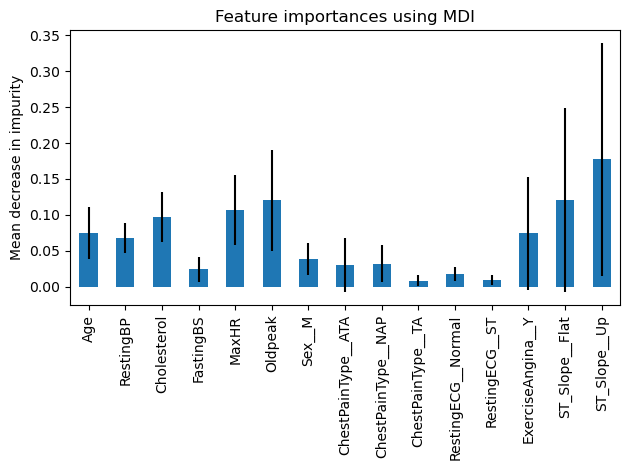

In [24]:
forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [25]:
import lime
import lime.lime_tabular

In [26]:
# predict_fn_rf = lambda x: rf.predict_proba(x).astype(float)
explainer = lime.lime_tabular.LimeTabularExplainer(X_test.values,feature_names = X_train.columns,class_names=['No Heart Disease','Heart Disease'])

In [27]:
# Finding Some data here the ST_Slope__Up is 1 , and the max heart rate is high
X_train[X_train["ST_Slope__Up"] == 1].sort_values(by=['MaxHR'], ascending=False)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex__M,ChestPainType__ATA,ChestPainType__NAP,ChestPainType__TA,RestingECG__Normal,RestingECG__ST,ExerciseAngina__Y,ST_Slope__Flat,ST_Slope__Up
829,29,130,204,0,202,0.0,1,1,0,0,0,0,0,0,1
753,34,118,210,0,192,0.7,0,1,0,0,1,0,0,0,1
126,34,130,161,0,190,0.0,0,1,0,0,1,0,0,0,1
866,44,130,219,0,188,0.0,1,1,0,0,0,0,0,0,1
171,40,140,235,0,188,0.0,1,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,62,120,220,0,86,0.0,1,0,0,0,0,1,0,0,1
551,62,120,220,0,86,0.0,1,0,1,0,0,0,0,0,1
331,56,115,0,1,82,-1.0,1,0,0,0,0,1,0,0,1
507,40,106,240,0,80,0.0,1,0,1,0,1,0,1,0,1


In [28]:
X_test.loc[[180]]

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex__M,ChestPainType__ATA,ChestPainType__NAP,ChestPainType__TA,RestingECG__Normal,RestingECG__ST,ExerciseAngina__Y,ST_Slope__Flat,ST_Slope__Up
180,52,130,225,0,120,2.0,1,0,0,0,1,0,1,1,0


In [29]:
target_exp = X_test.loc[[180]].values[0]
exp = explainer.explain_instance(target_exp, rf.predict_proba, num_features=20)
exp.show_in_notebook()

/home/gregorywpower/anaconda3/envs/BuildingDSSWithAnaconda/lib/python3.10/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [30]:
rf.feature_importances_

array([0.07512137, 0.06840827, 0.09654609, 0.02406867, 0.10709284,
       0.12043762, 0.03859523, 0.03003901, 0.03202176, 0.0083039 ,
       0.01728998, 0.00939579, 0.07429041, 0.12111211, 0.17727695])

In [31]:
rf.feature_names_in_

array(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak',
       'Sex__M', 'ChestPainType__ATA', 'ChestPainType__NAP',
       'ChestPainType__TA', 'RestingECG__Normal', 'RestingECG__ST',
       'ExerciseAngina__Y', 'ST_Slope__Flat', 'ST_Slope__Up'],
      dtype=object)

In [32]:
data = {"Features": rf.feature_names_in_, "Importance":rf.feature_importances_}
pd.DataFrame(data).sort_values("Importance", ascending=False)

,Features,Importance
14,ST_Slope__Up,0.177277
13,ST_Slope__Flat,0.121112
5,Oldpeak,0.120438
4,MaxHR,0.107093
2,Cholesterol,0.096546
0,Age,0.075121
12,ExerciseAngina__Y,0.074290
1,RestingBP,0.068408
6,Sex__M,0.038595
8,ChestPainType__NAP,0.032022


### Scratch/Notes

- Look at explainability across the different model types

# HEADING 5: Shapley Values (SHAP)

## Using Shapley

In [33]:
import shap

/home/gregorywpower/anaconda3/envs/BuildingDSSWithAnaconda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [34]:
X_train_summary = shap.kmeans(X_train, 50)
# X_train_summary = shap.sample(X_train,50)

In [35]:
X_train_summary

In [36]:
shap.initjs()

In [37]:
exp = shap.KernelExplainer(rf.predict_proba, X_train_summary)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


In [38]:
shap_values = exp.shap_values(X_test.iloc[[180]])

  0%|          | 0/1 [00:00<?, ?it/s]X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a Sta

In [39]:
X_test.iloc[[180]]

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex__M,ChestPainType__ATA,ChestPainType__NAP,ChestPainType__TA,RestingECG__Normal,RestingECG__ST,ExerciseAngina__Y,ST_Slope__Flat,ST_Slope__Up
847,45,115,260,0,185,0.0,1,0,0,0,0,0,0,0,1


In [40]:
shap.initjs()
shap.force_plot(exp.expected_value[0], shap_values[0], X_test.loc[[686]])

In [41]:
shap.initjs()
shap.force_plot(exp.expected_value[0], shap_values[0], X_test.loc[[412]])

In [42]:
shap_values_2 = exp.shap_values(X_test.loc[[439]])
shap.force_plot(exp.expected_value[0], shap_values_2[0], X_test.loc[[439]])

  0%|          | 0/1 [00:00<?, ?it/s]X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a Sta

In [43]:
exp = shap.KernelExplainer(rf.predict_proba, X_train)
shap_values = exp.shap_values(X_test)
shap.force_plot(exp.expected_value[0], shap_values[0], X_test)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
Using 734 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|          | 0/184 [00:00<?, ?it/s]X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weig

In [44]:
exp = shap.TreeExplainer(rf, X_train)

In [45]:
shap_values = exp.shap_values(X_test.iloc[[180]])

In [46]:
shap.force_plot(exp.expected_value[0], shap_values[0], X_test.iloc[[180]])